# Facial Emotion Recogination

## importing libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from zipfile import ZipFile
import os

#Connecting to google drive to insert dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Copying dataset to current directory

In [ ]:
!ls "/content/drive/My Drive/Facial Emotion Recognition"
!cp "/content/drive/My Drive/Facial Emotion Recognition/archive.zip" "archive.zip"


archive.zip


#Extracting zipped dataset

In [ ]:
file_name = "archive.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Importing Dataset

In [ ]:
#Training directory after extracting zip files
train_dir = 'train/'
#Testing directory after extracting zip files
test_dir = 'test/'

#Size of image in height and width as row and col
row, col = 48, 48
#number of emotion classes to be classified
classes = 7

#Function to calculate number of dataset present in every classes in dataset
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       disgust  angry  surprise  happy  neutral   sad  fear
train      436   3995      3171   7215     4965  4830  4097
      disgust  angry  surprise  happy  neutral   sad  fear
test      111    958       831   1774     1233  1247  1024


### PLot of number of images in training set

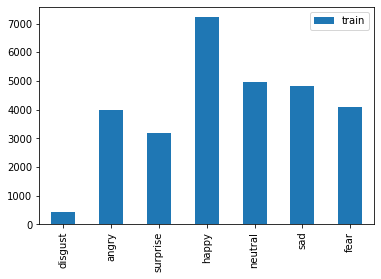

In [ ]:
train_count.transpose().plot(kind='bar')

### PLot of number of images in test set

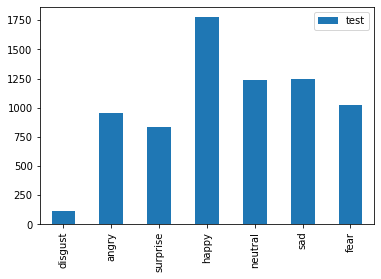

In [ ]:
test_count.transpose().plot(kind='bar')

#Plotting first images of exery emotions

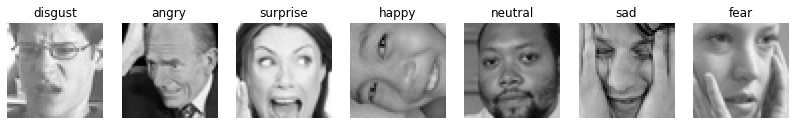

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating Training and test sets

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Defining Model

In [ ]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
my_model = get_model((row,col,1), classes)
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


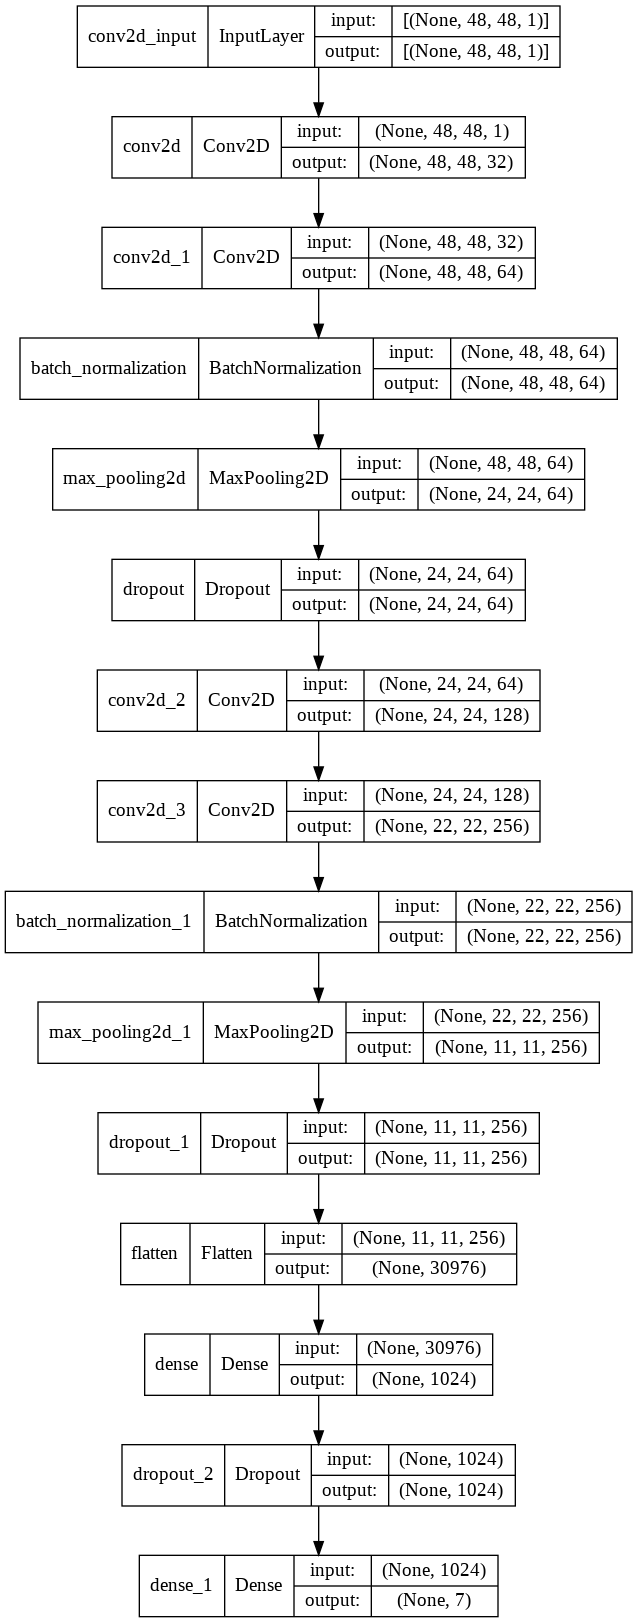

In [ ]:
plot_model(my_model, to_file='my_model.png', show_shapes=True, show_layer_names=True)

### Callbacks Function

In [ ]:
chk_path = 'my_model.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

## Training Model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = my_model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.2926 - accuracy: 0.2818
Epoch 00001: val_loss improved from inf to 7.51538, saving model to my_model.h5
448/448 [==============================] - 50s 82ms/step - loss: 4.2926 - accuracy: 0.2818 - val_loss: 7.5154 - val_accuracy: 0.1848 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.5021 - accuracy: 0.3439
Epoch 00002: val_loss improved from 7.51538 to 3.15633, saving model to my_model.h5
448/448 [==============================] - 36s 80ms/step - loss: 3.5021 - accuracy: 0.3439 - val_loss: 3.1563 - val_accuracy: 0.3991 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 2.9939 - accuracy: 0.3740
Epoch 00003: val_loss improved from 3.15633 to 2.71835, saving model to my_model.h5
448/448 [==============================] - 36s 81ms/step - loss: 2.9939 - accuracy: 0.3740 - val_loss: 2.7184 - val_accuracy: 0.4107 - lr: 1.0000e-04
Epoch 4/60
448

## Loss and Accuracy plot

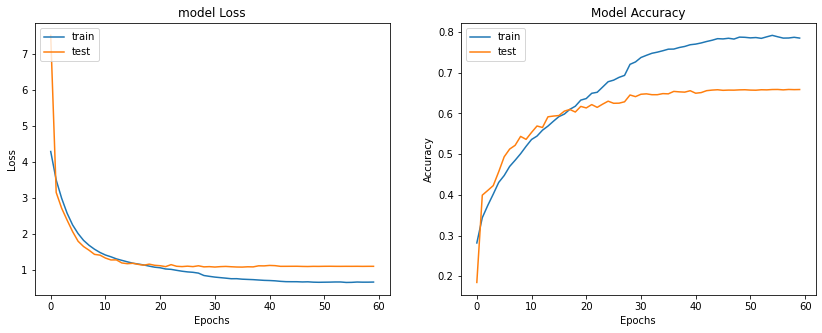

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

high accracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can be seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset

### Model evaluation

In [ ]:
train_loss, train_accu = my_model.evaluate(training_set)
test_loss, test_accu = my_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 29ms/step - loss: 1.1071 - accuracy: 0.6584
final train accuracy = 86.13 , validation accuracy = 65.84


In [ ]:
my_model.save_weights('my_model_bestweight.h5')

### Confusion Matrix and Classification on training set

Confusion Matrix
[[ 548   39  518 1032  792  672  394]
 [  58    5   55  116   77   67   58]
 [ 552   59  527 1039  724  741  455]
 [ 935  110  993 1854 1316 1210  797]
 [ 695   63  573 1322  867  850  595]
 [ 633   52  612 1217  920  849  547]
 [ 419   43  404  868  585  515  337]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.13      0.14      4097
       happy       0.25      0.26      0.25      7215
     neutral       0.16      0.17      0.17      4965
         sad       0.17      0.18      0.17      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



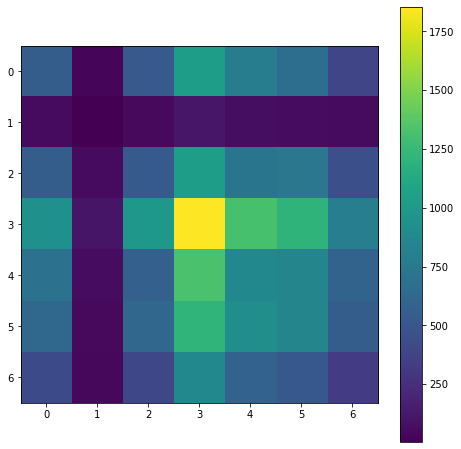

In [ ]:
y_pred = my_model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
# tick_mark = np.arange(len(target_names))
# _ = plt.xticks(tick_mark, target_names, rotation=90)
# _ = plt.yticks(tick_mark, target_names)

### Confusion Matrix and Classification on test set

Confusion Matrix
[[144   3 106 234 191 154 126]
 [ 14   2   5  42  19  21   8]
 [141   9 108 256 225 168 117]
 [271  20 220 410 339 324 190]
 [170   7 143 302 242 215 154]
 [193  21 141 321 221 218 132]
 [131   7  93 222 152 133  93]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.03      0.02      0.02       111
        fear       0.13      0.11      0.12      1024
       happy       0.23      0.23      0.23      1774
     neutral       0.17      0.20      0.18      1233
         sad       0.18      0.17      0.18      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



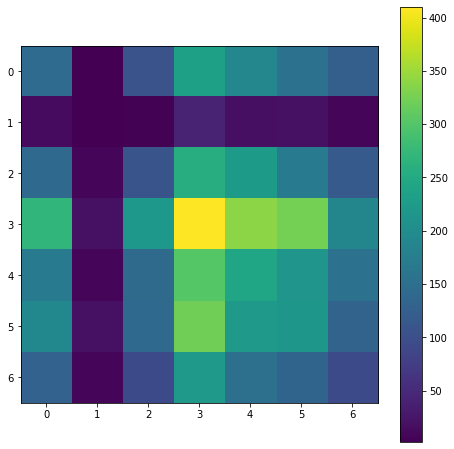

In [ ]:
y_pred = my_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
# tick_mark = np.arange(len(target_names))
# _ = plt.xticks(tick_mark, target_names, rotation=90)
# _ = plt.yticks(tick_mark, target_names)

#To test with other images to find emotions

In [ ]:
image_path = "images.jpg"
image = load_img(image_path, color_mode='grayscale', target_size=(48,48))
plt.imshow(image)
plt.axis('off')
plt.show()
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr]) 
predictions = my_model.predict(input_arr)

y_pred = np.argmax(predictions, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}
for i in range(len(predictions[0])):
  if predictions[0][i] ==1:
    print(class_labels[i])

FileNotFoundError: ignored